# **Blindness Detection Project**

## **Dataset Description**

This project aims to detect "Diabetic Retinopathy (DR)" to stop blindness at early stage.

A clinician has rated each image for the severity of diabetic retinopathy on a scale of 0 to 4:

<ul>
<li>0 - No DR</li>
<li>1 - Mild</li>
<li>2 - Moderate</li>
<li>3 - Severe</li>
<li>4 - Proliferative DR (Worst Case)</li>
</ul>

**Dataset Source -** *https://www.kaggle.com/competitions/aptos2019-blindness-detection/data?select=train_images*

**What is Diabetic Retinopathy?**

Diabetic retinopathy is an eye condition that can cause vision loss and blindness in people who have diabetes. It affects blood vessels in the retina (the light-sensitive layer of tissue in the back of your eye).

**Symptoms**

<ul>
<li>Early Symptoms: None</li>
<li>Later Symptoms: Blurry Vision, floating spots in vision, blindness</li>
</ul>

**Diagnosis -** Dilated eye exam
<br>
**Treatment -** Injections, laser treatment, surgery
<br>
**Source -** *https://www.nei.nih.gov/learn-about-eye-health/eye-conditions-and-diseases/diabetic-retinopathy*

## **Importing Dependencies**

In [1]:
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pyplot as pyplot
from PIL import Image
import matplotlib.image as mpimg
import seaborn as sns
import math

from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import compute_class_weight
from keras import models, applications, layers
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Activation
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## **Dataset Setup**

**Step 1: Setting the Directory**

In [29]:
# Base directory
base_dir = '/Users/reemikadas/Desktop/SCU MSBA/Github/Machine-Learning-Projects/Project 7_Blindness Detection using Deep Learning'

# Data Directory
data_dir = os.path.join(base_dir, 'Data')

# --- Train Set ---
train_img_dir = os.path.join(data_dir, 'train_data')
train_csv_path = os.path.join(data_dir, 'train_data.csv')

# --- Validation Set ---
val_img_dir = os.path.join(data_dir, 'val_data')
val_csv_path = os.path.join(data_dir, 'val_data.csv')

# --- Test Set ---
test_img_dir = os.path.join(data_dir, 'test_data')
test_csv_path = os.path.join(data_dir, 'test_data.csv')

**Step 2: Loading the Directory**

In [30]:
# --- Load CSV files ---
train_df = pd.read_csv(train_csv_path)
val_df = pd.read_csv(val_csv_path)
test_df = pd.read_csv(test_csv_path)

# Glimpse of Train DF
train_df.head()

id_code  diagnosis                                         image_path
0  c76664770c07          3  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...
1  7b29e3783919          3  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...
2  cd3fd04d72f5          2  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...
3  f64b6e85f1c9          0  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...
4  00f6c1be5a33          0  /content/drive/MyDrive/Quarter_4_SCU/Deep_Lear...

## **Data Exploration**

In [31]:
# Dropping the Image_path
train_df.drop('image_path', axis=1, inplace = True)
val_df.drop('image_path', axis=1, inplace = True)
test_df.drop('image_path', axis=1, inplace = True)

# Verify
train_df.columns
val_df.columns
test_df.columns

Index(['id_code', 'diagnosis'], dtype='object')

In [32]:
print("Train samples:", len(train_df))
print("Validation samples:", len(val_df))
print("Test samples:", len(test_df))

Train samples: 2662
Validation samples: 200
Test samples: 800


In [33]:
# Append the .png extension and join with folder path
train_df['image_path'] = train_df['id_code'].apply(lambda x: os.path.join(train_img_dir, f"{x}.png"))
val_df['image_path']   = val_df['id_code'].apply(lambda x: os.path.join(val_img_dir, f"{x}.png"))
test_df['image_path']  = test_df['id_code'].apply(lambda x: os.path.join(test_img_dir, f"{x}.png"))

In [34]:
train_df.head()

id_code  diagnosis                                         image_path
0  c76664770c07          3  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...
1  7b29e3783919          3  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...
2  cd3fd04d72f5          2  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...
3  f64b6e85f1c9          0  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...
4  00f6c1be5a33          0  /Users/reemikadas/Desktop/SCU MSBA/Github/Mach...

In [8]:
missing_train = [p for p in train_df['image_path'] if not os.path.exists(p)]
print(f"Missing {len(missing_train)} image files from Train data.")

missing_val = [p for p in val_df['image_path'] if not os.path.exists(p)]
print(f"Missing {len(missing_val)} image files from Validation data.")

missing_test = [p for p in test_df['image_path'] if not os.path.exists(p)]
print(f"Missing {len(missing_test)} image files from Test data.")

Missing 0 image files from Train data.
Missing 0 image files from Validation data.
Missing 0 image files from Test data.


In [9]:
# Define the Class Labels
label_info = {'0':"No DR", '1':"Mild DR", '2':"Moderate DR", '3':"Severe DR", '4':"Proliferative DR"}
print("Label Information: {}\n".format(label_info))

class_names = list(label_info.values())
print("Class Names: {}\n".format(class_names))

num_classes = train_df['diagnosis'].nunique()
print("Total Number of Classes: {}".format(num_classes))

Label Information: {'0': 'No DR', '1': 'Mild DR', '2': 'Moderate DR', '3': 'Severe DR', '4': 'Proliferative DR'}

Class Names: ['No DR', 'Mild DR', 'Moderate DR', 'Severe DR', 'Proliferative DR']

Total Number of Classes: 5


In [10]:
# Checking the Data Type
train_df.info()
val_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     2662 non-null   object
 1   diagnosis   2662 non-null   int64 
 2   image_path  2662 non-null   object
dtypes: int64(1), object(2)
memory usage: 62.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     200 non-null    object
 1   diagnosis   200 non-null    int64 
 2   image_path  200 non-null    object
dtypes: int64(1), object(2)
memory usage: 4.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     800 non-null    object
 1   diagnosis   800 non-null    int64 
 2   image_path  800 non-

In [11]:
# Converting target variable from integer to string
train_df['diagnosis'] = train_df['diagnosis'].astype(str)
val_df['diagnosis'] = val_df['diagnosis'].astype(str)
test_df['diagnosis'] = test_df['diagnosis'].astype(str)

# Verify the Data Type
train_df.info()
val_df.info()
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2662 entries, 0 to 2661
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     2662 non-null   object
 1   diagnosis   2662 non-null   object
 2   image_path  2662 non-null   object
dtypes: object(3)
memory usage: 62.5+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     200 non-null    object
 1   diagnosis   200 non-null    object
 2   image_path  200 non-null    object
dtypes: object(3)
memory usage: 4.8+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 800 entries, 0 to 799
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   id_code     800 non-null    object
 1   diagnosis   800 non-null    object
 2   image_path  800 non-null    object
dtype

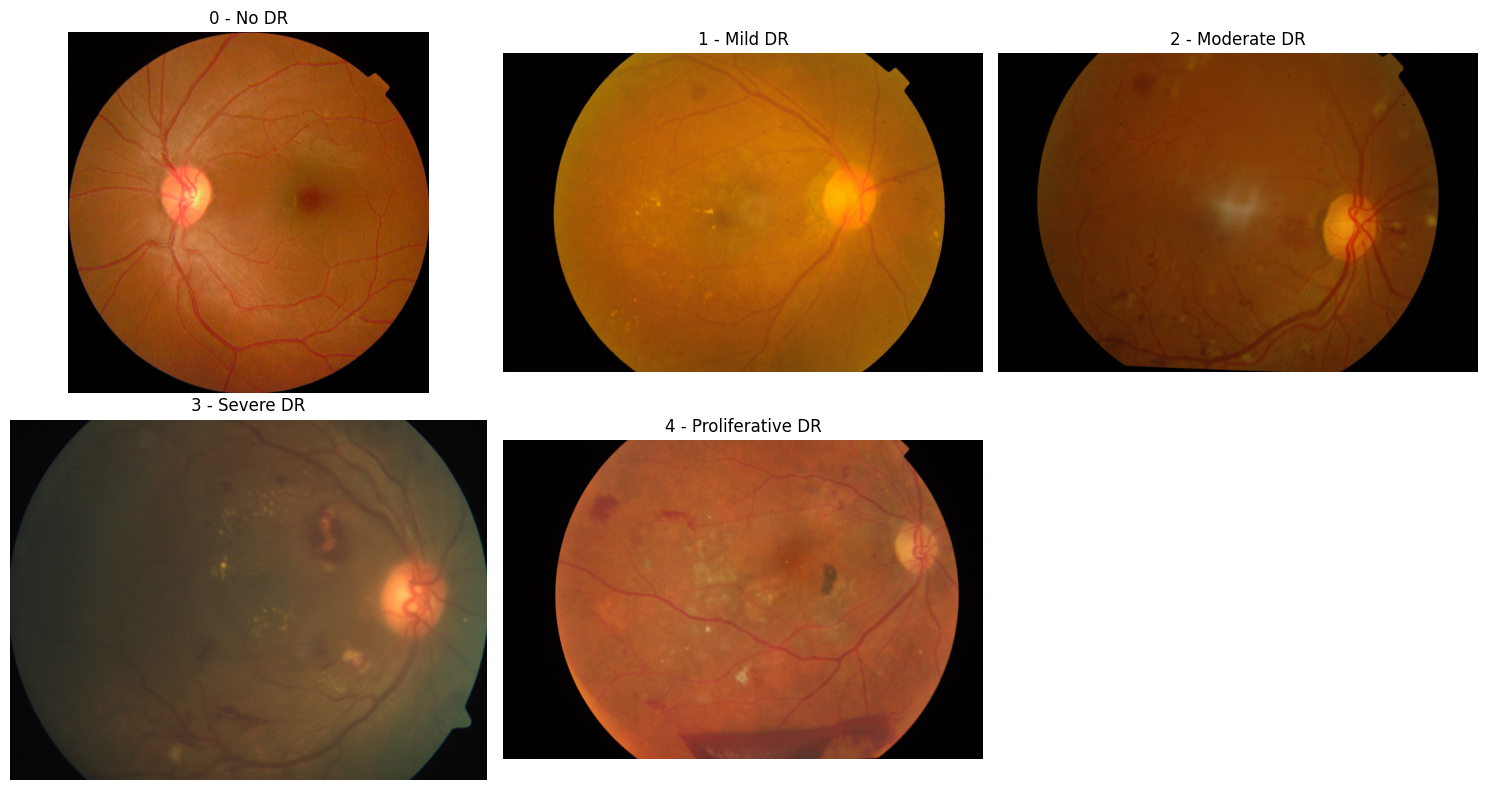

In [12]:
# Display the sample images

plt.figure(figsize = (15,8))

for i, cls in enumerate(sorted(train_df['diagnosis'].unique())):
  sample = train_df[train_df['diagnosis'] == cls].iloc[0]
  img = Image.open(sample['image_path'])

  plt.subplot(2, 3, i + 1)
  plt.imshow(img)
  plt.axis('off')
  plt.title(f"{cls} - {label_info[cls]}")

plt.subplot(2,3,6)
plt.axis('off')
plt.tight_layout()
plt.show()

## **Image Preprocessing (Data Augmentation + Normalization)**

In [13]:
# Data Augmentation Parameter for Training Data
data_augment_train = ImageDataGenerator(
                                          rescale = 1./255,
                                          rotation_range = 20,
                                          width_shift_range = 0.05,
                                          height_shift_range = 0.05,
                                          shear_range = 0.05,
                                          zoom_range = 0.2,
                                          horizontal_flip = True
                                        )

# Data Augmentation Parameter for Validation and Test Data
data_augment_val_test = ImageDataGenerator(
                                            rescale = 1./255
                                          )

# Applying Data Augmentation on Training Data
train_data_gen = data_augment_train.flow_from_dataframe(
                                                          dataframe = train_df,
                                                          x_col = 'image_path',
                                                          y_col = 'diagnosis',
                                                          batch_size = 32,
                                                          target_size = (224, 224),
                                                          class_mode = 'categorical',
                                                          shuffle = True
                                                        )

# Applying Data Augmentation on Validation and Test Data
val_data_gen = data_augment_val_test.flow_from_dataframe(
                                                            dataframe = val_df,
                                                            x_col = 'image_path',
                                                            y_col = 'diagnosis',
                                                            batch_size = 10,
                                                            target_size = (224, 224),
                                                            class_mode = 'categorical',
                                                            shuffle = False
                                                        )

test_data_gen = data_augment_val_test.flow_from_dataframe(
                                                            dataframe = test_df,
                                                            x_col = 'image_path',
                                                            y_col = 'diagnosis',
                                                            batch_size = 10,
                                                            target_size = (224, 224),
                                                            class_mode = 'categorical',
                                                            shuffle = False
                                                        )

Found 2662 validated image filenames belonging to 5 classes.
Found 200 validated image filenames belonging to 5 classes.
Found 800 validated image filenames belonging to 5 classes.


In [26]:
# Function to Plot Images
def plotImages(imagesList):
  fig, axes = pyplot.subplots(1, len(imagesList), figsize = (20,20))
  axes = axes.flatten()
  for img, ax in zip(imagesList, axes):
    ax.imshow(img)
  pyplot.tight_layout()
  pyplot.show()

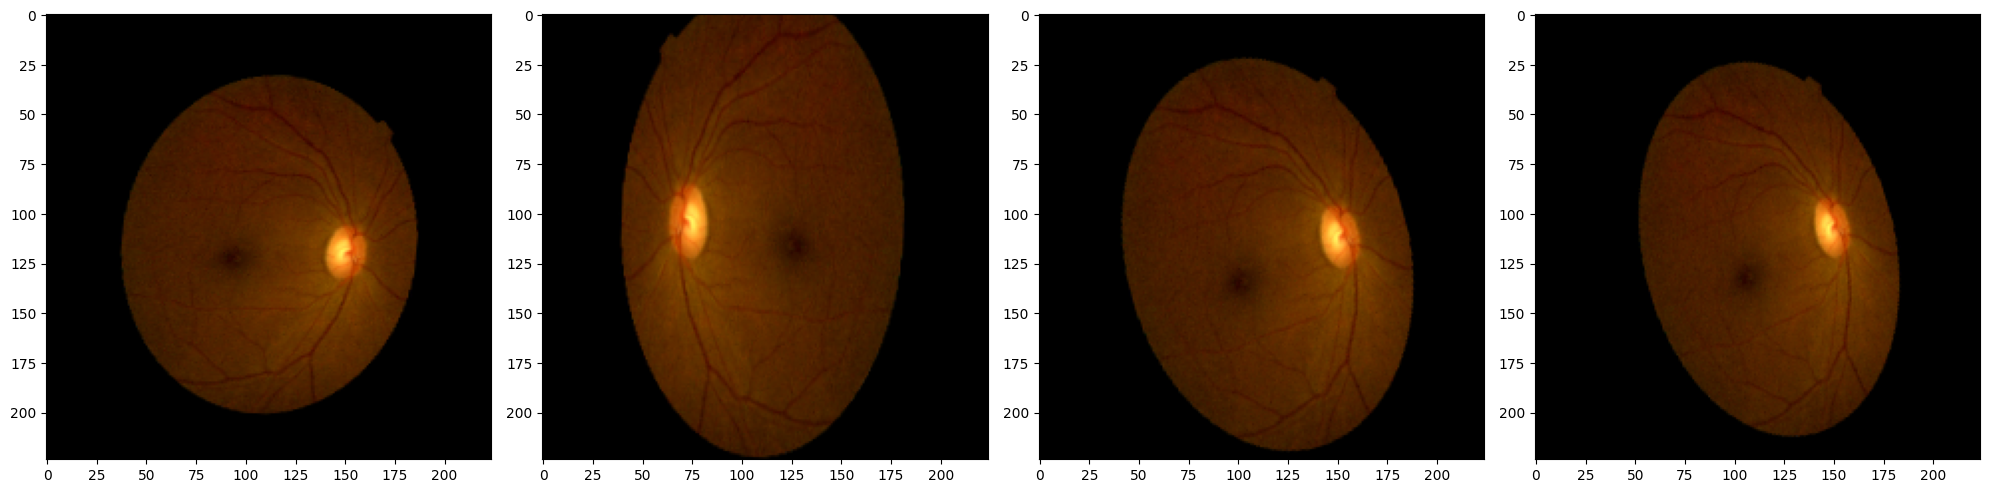

In [27]:
augmented_images = [train_data_gen[0][0][0] for i in range(4)]
plotImages(augmented_images)

The above 4 images shows different variants of an image after applying Data Augmentation.

## **Model Development**

#### **Convolutional Neural Networks (CNNs)**

In [14]:
# CNN Architecture
input_shape = (224,224,3)
conv_size = 3
conv_filter_1 = 128
conv_filter_2 = 256
conv_filter_3 = 512
conv_stride = 1
poolSize = 2
pool_stride = 2
fc_node_1 = 128
fc_node_2 = 64
output_node = num_classes
pad = 'same'
inner_activ = 'relu'
outer_activ = 'softmax'

# CNN Model Development
cnn_model = models.Sequential()

# -- Input Layer --
cnn_model.add(Input(shape = input_shape))

# -- Convolutional Block 1 --
cnn_model.add(Conv2D(filters = conv_filter_1, kernel_size = conv_size, strides = conv_stride,
                     padding = pad, activation = inner_activ, name = 'conv_1'))

cnn_model.add(MaxPooling2D(pool_size = poolSize, strides = pool_stride, name = 'pool_1'))

# -- Convolutional Block 2 --
cnn_model.add(Conv2D(filters = conv_filter_2, kernel_size = conv_size, strides = conv_stride,
                     padding = pad, activation = inner_activ, name = 'conv_2'))

cnn_model.add(MaxPooling2D(pool_size = poolSize, strides = pool_stride, name = 'pool_2'))

# -- Convolutional Block 3 --
cnn_model.add(Conv2D(filters = conv_filter_3, kernel_size = conv_size, strides = conv_stride,
                     padding = pad, activation = inner_activ, name = 'conv_3'))

cnn_model.add(MaxPooling2D(pool_size = poolSize, strides = pool_stride, name = 'pool_3'))

# -- Flatten --
cnn_model.add(Flatten())

# -- Fully Connected Layer --
cnn_model.add(Dense(fc_node_1, activation = inner_activ))
#cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(fc_node_2, activation = inner_activ))
#cnn_model.add(Dropout(0.2))
cnn_model.add(Dense(output_node, activation = outer_activ))

# CNN Model Summary
cnn_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv_1 (Conv2D)                 │ (None, 224, 224, 128)  │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_1 (MaxPooling2D)           │ (None, 112, 112, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_2 (Conv2D)                 │ (None, 112, 112, 256)  │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_2 (MaxPooling2D)           │ (None, 56, 56, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_3 (Conv2D)                 │ (None, 56, 56, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ pool_3 (MaxPooling2D)           │ (None, 28, 28, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 401408)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    51,380,352 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,867,845 (201.67 MB)

 Trainable params: 52,867,845 (201.67 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Compile the CNN Model
grad_desc = keras.optimizers.Adam(learning_rate=1e-3)
loss_function = 'categorical_crossentropy'
performance = ['accuracy']

cnn_model.compile(optimizer = grad_desc, loss = loss_function, metrics = performance)

# Handling Class Imbalance
class_weights = compute_class_weight('balanced', classes=np.unique(train_df['diagnosis']), y=train_df['diagnosis'])
class_weight_dict = dict(enumerate(class_weights))

# CallBack
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5,
                                           restore_best_weights=True)

# Fit the CNN Model
cnn_trained = cnn_model.fit(train_data_gen,
                            steps_per_epoch = len(train_data_gen),
                            epochs = 20,
                            validation_data = val_data_gen,
                            validation_steps = len(val_data_gen),
                            class_weight = class_weight_dict,
                            callbacks=[early_stop]
                            )

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 476s 6s/step - accuracy: 0.4136 - loss: 1.5856 - val_accuracy: 0.5900 - val_loss: 0.9125
Epoch 2/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 500s 6s/step - accuracy: 0.5135 - loss: 1.3541 - val_accuracy: 0.5450 - val_loss: 1.0338
Epoch 3/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 467s 6s/step - accuracy: 0.5428 - loss: 1.3069 - val_accuracy: 0.6300 - val_loss: 0.8658
Epoch 4/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 480s 6s/step - accuracy: 0.5826 - loss: 1.2908 - val_accuracy: 0.5700 - val_loss: 0.9857
Epoch 5/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 480s 6s/step - accuracy: 0.5789 - loss: 1.2574 - val_accuracy: 0.6650 - val_loss: 0.8920
Epoch 6/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 483s 6s/step - accuracy: 0.5875 - loss: 1.2441 - val_accuracy: 0.6050 - val_loss: 0.8692
Epoch 7/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 494s 6s/step - accuracy: 0.6116 - loss: 1.2459 - val_accuracy: 0.5950 - val_loss: 0.9302
Epoch 8/20
84/84 ━━━━━━━━━━━━━━━━━━━━ 500s 6s/step - accuracy: 0.5811 - loss: 1.2567 - val_accuracy: 0.7300 - v

In [16]:
# History Table
cnn_history_df = pd.DataFrame(cnn_trained.history)
cnn_history_df.rename(columns = {'loss':'train_loss', 'accuracy':'train_accuracy'}, inplace = True)

cnn_history_df

train_accuracy  train_loss  val_accuracy  val_loss
0         0.413599    1.585588         0.590  0.912465
1         0.513524    1.354119         0.545  1.033793
2         0.542825    1.306939         0.630  0.865816
3         0.582645    1.290777         0.570  0.985739
4         0.578888    1.257420         0.665  0.891984
5         0.587528    1.244075         0.605  0.869249
6         0.611570    1.245870         0.595  0.930176
7         0.581142    1.256664         0.730  0.838740
8         0.611195    1.225171         0.680  0.836231
9         0.624343    1.226981         0.685  0.850793
10        0.639369    1.203399         0.745  0.829860
11        0.636364    1.219321         0.710  0.776943
12        0.618708    1.215913         0.705  0.813737
13        0.618708    1.223381         0.680  0.838738
14        0.635988    1.205695         0.715  0.839987
15        0.630729    1.193512         0.715  0.818650
16        0.622464    1.205360         0.735  0.801520

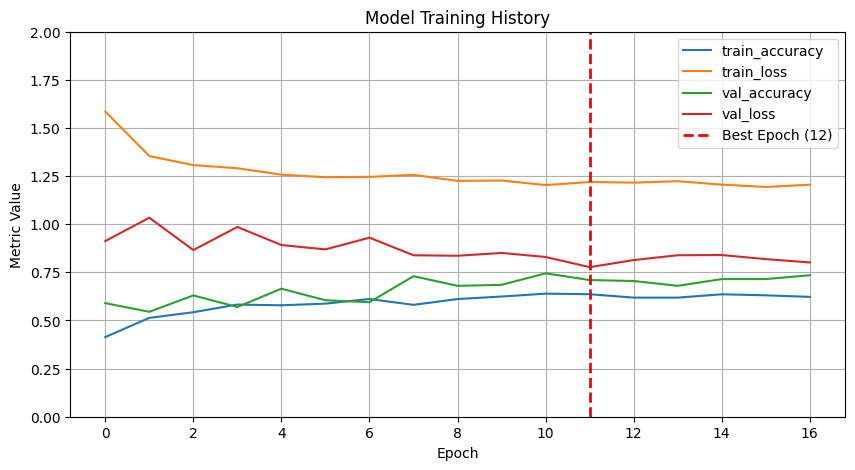

In [36]:
# Plot the Loss and Accuracy
def plot_loss_acc(history_df, ylim_x=0, ylim_y=2):
    best_epoch_index = history_df['val_loss'].idxmin()
    history_df.plot(figsize=(10, 5))

    pyplot.axvline(
        x=best_epoch_index, 
        color='r', 
        linestyle='--', 
        linewidth=2,
        label=f'Best Epoch ({best_epoch_index + 1})'
    )
    
    pyplot.gca().set_ylim(ylim_x, ylim_y)
    pyplot.title('Model Training History')
    pyplot.xlabel('Epoch')
    pyplot.ylabel('Metric Value')
    pyplot.legend()
    pyplot.grid(True)
    pyplot.show()

plot_loss_acc(cnn_history_df, ylim_x = 0, ylim_y = 2)

In [35]:
# Find the row with the minimum validation loss
best_epoch_row = cnn_history_df.loc[cnn_history_df['val_loss'].idxmin()]

# Extract the best metrics
best_train_loss = best_epoch_row['train_loss']
best_train_accuracy = best_epoch_row['train_accuracy']
best_val_loss = best_epoch_row['val_loss']
best_val_accuracy = best_epoch_row['val_accuracy']

# Print the Result
print("Training Accuracy: {:.2f}%".format(best_train_accuracy*100))
print("Validation Accuracy: {:.2f}%".format(best_val_accuracy*100))

Training Accuracy: 63.64%
Validation Accuracy: 71.00%


In [20]:
# Evaluate on Test Data
test_loss, test_acc = cnn_model.evaluate(test_data_gen)

print("Test Accuracy: {:.2f}%".format(test_acc*100))

/opt/anaconda3/envs/python311/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 554ms/step - accuracy: 0.6637 - loss: 0.9011
Test Accuracy: 66.37%


In [21]:
y_hat = cnn_model.predict(test_data_gen)
y_hat.round(3)

80/80 ━━━━━━━━━━━━━━━━━━━━ 45s 550ms/step


array([[0.862, 0.   , 0.047, 0.005, 0.086],
       [0.867, 0.001, 0.023, 0.003, 0.105],
       [0.361, 0.062, 0.183, 0.126, 0.268],
       ...,
       [0.004, 0.46 , 0.146, 0.213, 0.175],
       [0.005, 0.091, 0.349, 0.189, 0.367],
       [1.   , 0.   , 0.   , 0.   , 0.   ]], dtype=float32)

In [22]:
y_hat_class = np.argmax(y_hat, axis = 1)
y_hat_class

array([0, 0, 0, 0, 1, 1, 2, 2, 4, 0, 0, 0, 4, 0, 1, 0, 0, 1, 0, 2, 4, 0,
       3, 0, 1, 2, 0, 1, 0, 0, 2, 0, 1, 0, 0, 1, 0, 0, 0, 3, 0, 2, 0, 2,
       4, 0, 0, 4, 4, 0, 0, 0, 0, 3, 1, 4, 2, 0, 0, 2, 2, 0, 0, 4, 0, 3,
       0, 2, 4, 0, 2, 3, 2, 2, 1, 1, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       1, 2, 0, 0, 4, 4, 1, 4, 0, 0, 3, 0, 4, 0, 3, 1, 4, 0, 0, 4, 3, 0,
       1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 3, 1, 1, 0, 3, 1, 0, 0, 0, 4, 1, 0,
       4, 0, 0, 2, 0, 2, 0, 4, 1, 0, 1, 1, 0, 3, 2, 2, 0, 1, 0, 2, 0, 3,
       0, 0, 4, 1, 3, 4, 0, 2, 0, 0, 4, 0, 3, 0, 0, 3, 2, 0, 1, 0, 0, 0,
       4, 0, 0, 0, 0, 0, 0, 4, 4, 0, 0, 4, 0, 0, 1, 1, 0, 0, 0, 2, 0, 2,
       1, 4, 0, 2, 0, 0, 3, 4, 0, 1, 0, 1, 0, 4, 1, 4, 0, 0, 0, 0, 2, 3,
       0, 0, 1, 2, 0, 0, 0, 4, 0, 0, 0, 1, 4, 1, 0, 1, 0, 0, 0, 0, 4, 0,
       4, 0, 0, 1, 4, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       2, 0, 0, 0, 2, 1, 1, 0, 0, 3, 0, 2, 3, 2, 0, 2, 2, 0, 4, 4, 0, 1,
       0, 3, 0, 3, 0, 1, 0, 0, 0, 2, 2, 1, 4, 0, 0,

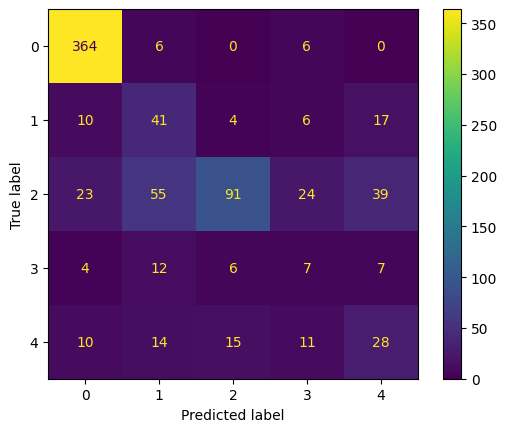

In [23]:
y_true = test_df['diagnosis'].astype(int).values
y_pred = np.array(y_hat_class).astype(int)

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix heatmap
display = ConfusionMatrixDisplay(confusion_matrix = cm)
display.plot()

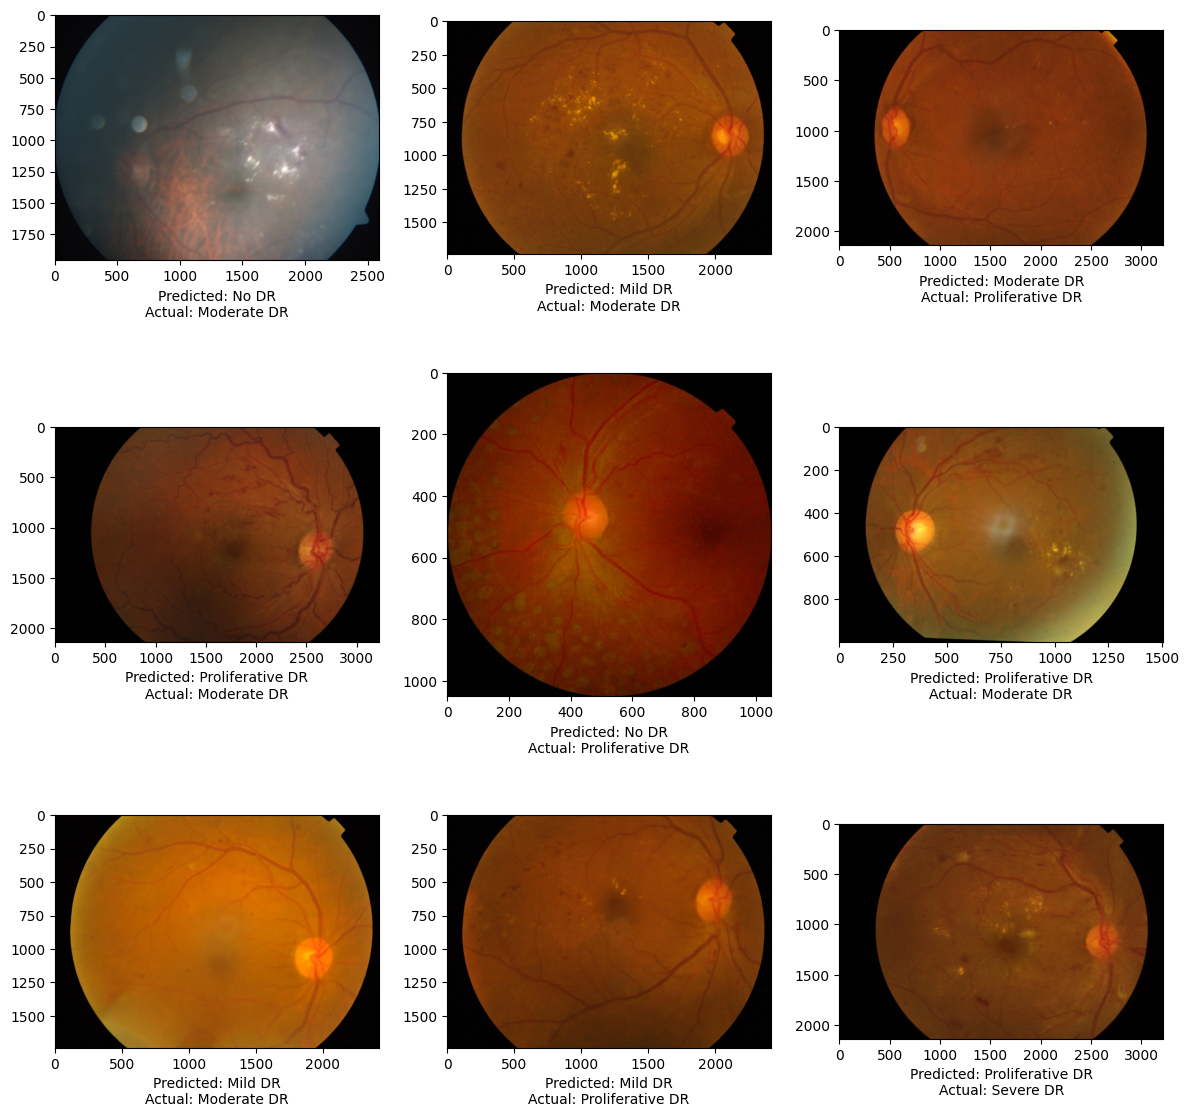

In [24]:
errorCnt = 9
tCnt = 0
index = 0

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

while tCnt < errorCnt and index < len(test_df):
    actual_class = int(test_df.loc[index, 'diagnosis'])
    img_path = test_df.loc[index, 'image_path']
    pred_class = y_hat_class[index]

    if pred_class != actual_class:
        img = mpimg.imread(img_path)
        axes.flat[tCnt].imshow(img)
        axes.flat[tCnt].set_xlabel(
            f"Predicted: {class_names[pred_class]}\nActual: {class_names[actual_class]}"
        )
        tCnt += 1
    index += 1

plt.tight_layout()
plt.show()

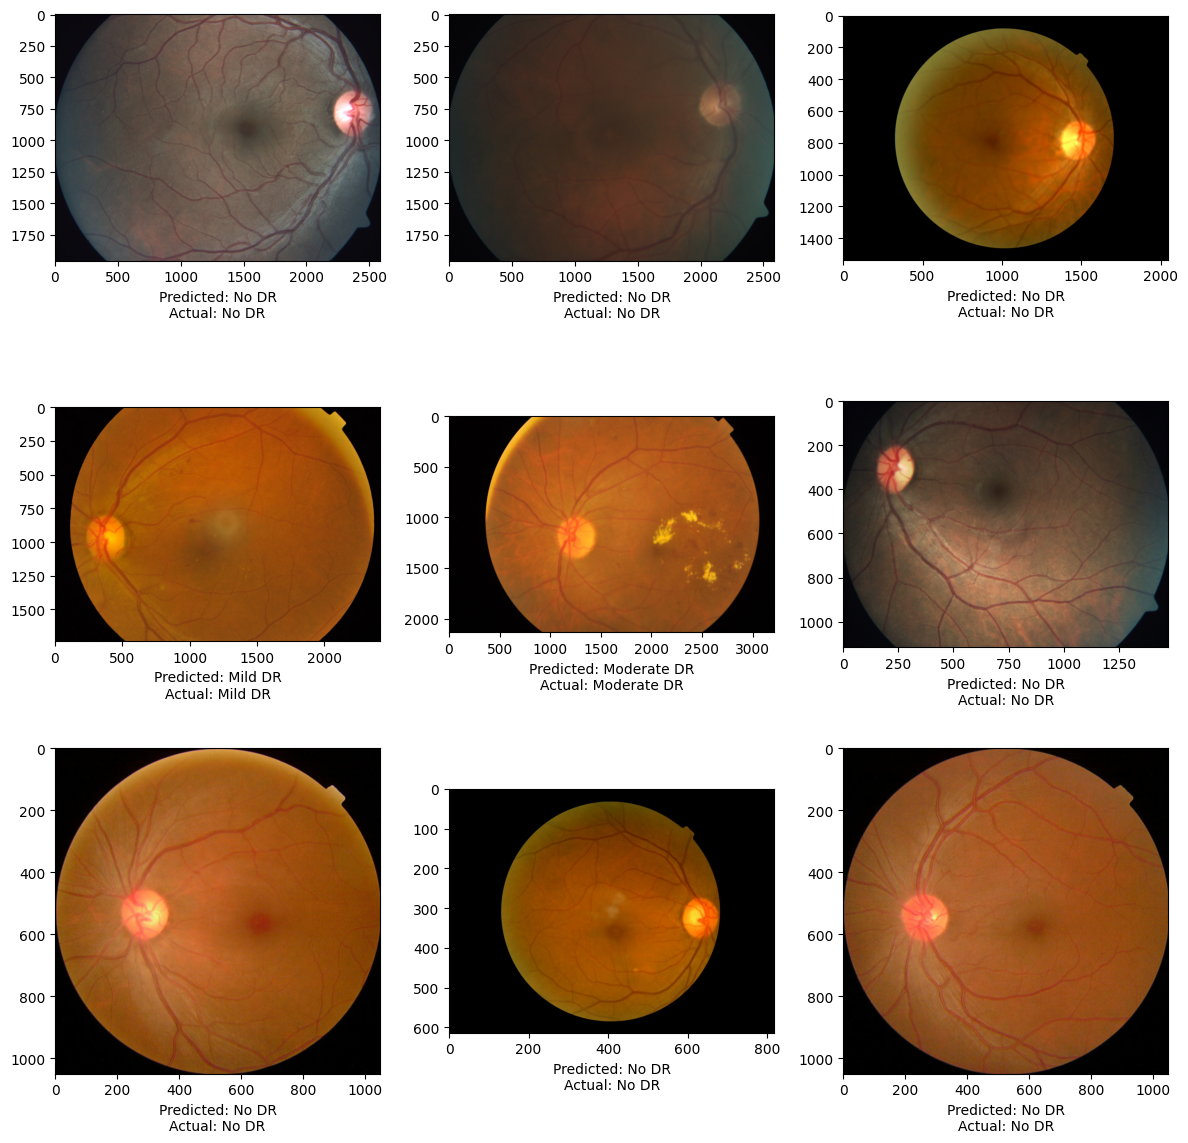

In [25]:
errorCnt = 9
tCnt = 0
index = 0

fig, axes = plt.subplots(3, 3, figsize=(12, 12))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

while tCnt < errorCnt and index < len(test_df):
    actual_class = int(test_df.loc[index, 'diagnosis'])
    img_path = test_df.loc[index, 'image_path']
    pred_class = y_hat_class[index]

    if pred_class == actual_class:
        img = mpimg.imread(img_path)
        axes.flat[tCnt].imshow(img)
        axes.flat[tCnt].set_xlabel(
            f"Predicted: {class_names[pred_class]}\nActual: {class_names[actual_class]}"
        )
        tCnt += 1
    index += 1

plt.tight_layout()
plt.show()